In [15]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, RocCurveDisplay
import xgboost as xgb

In [16]:
path = os.path.abspath('..') + '/' + "datasets/model_dataset.csv"

df = pd.read_csv(path)

attack_cols = ['label_spoofing', 'label_mitm', 'label_ddos', 'label_gps_spoofing', 'label_malware', 'label_jamming', 'label_protocol_exploit']
df = df.drop(['timestamp', 'drone_gps_coordinates', 'label_normal'], axis=1)
df['anomaly'] = df[attack_cols].max(axis=1)
df = df.drop(columns=attack_cols)

encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
encoded_features = encoder.fit_transform(df[['communication_protocol', 'encryption_type']])
encoded_df = pd.DataFrame(encoded_features, columns=encoder.get_feature_names_out(['communication_protocol', 'encryption_type']))
df = pd.concat([df.drop(['communication_protocol', 'encryption_type'], axis=1), encoded_df], axis=1)

labels = df['anomaly']

legit = df[labels == 0].copy()
jamming = df[labels  == 1].copy()

features = df.columns.to_numpy()
features = np.delete(features, -1)

X = df[features]
y = df['anomaly'] 

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
pca = PCA(n_components=0.95)
X_pca = pca.fit_transform(X_scaled)


In [17]:
X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.2, random_state=42)

model = xgb.XGBClassifier(n_estimators=100, max_depth=6, learning_rate=0.1, objective='binary:logistic')
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

Accuracy:  99.65
Precision score:  99.77
Recall score:  99.03
F-1 score:  99.4


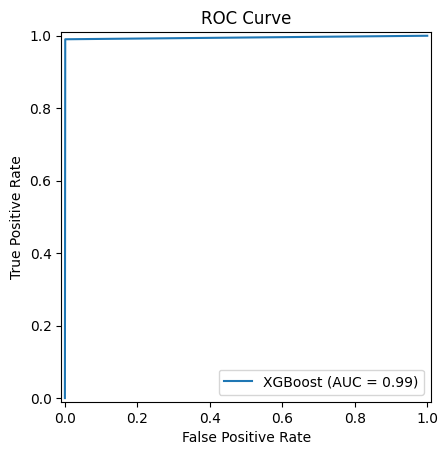

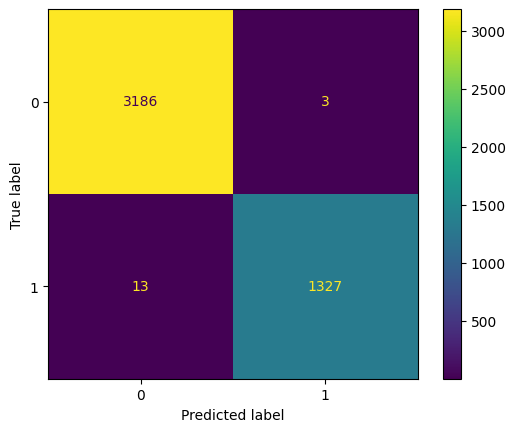

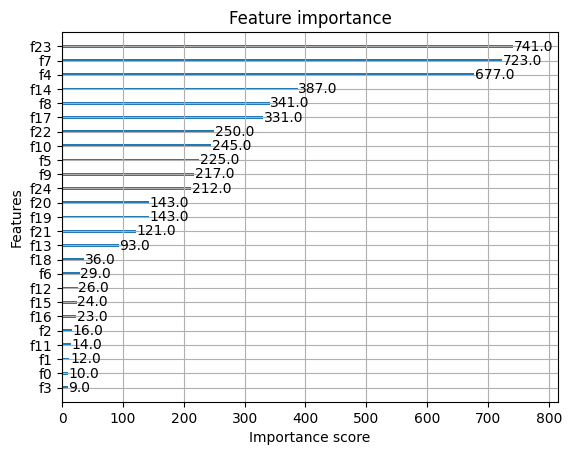

In [18]:
# METRICS
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: ", round(accuracy*100, 2))

precision = precision_score(y_test, y_pred)
print("Precision score: ", round(precision*100, 2))

recall = recall_score(y_test, y_pred)
print("Recall score: ", round(recall*100, 2))

f1_score = f1_score(y_test, y_pred)
print("F-1 score: ", round(f1_score*100, 2))

#ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred)

display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, name='XGBoost')
display.plot()
plt.title('ROC Curve')
plt.show()

#Confusion matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

xgb.plot_importance(model)
plt.show()

In [19]:
import joblib
joblib.dump(model, "xgb_model.pkl")



['xgb_model.pkl']